### 1. PyTorch简介
Pytorch是Facebook 的 AI 研究团队发布了一个基于 Python的科学计算包，旨在服务两类场合：
1. 替代numpy发挥GPU潜能
2. 一个提供了高度灵活性和效率的深度学习实验性平台

### 2.PyTorch特点
* PyTorch 提供了运行在 GPU/CPU 之上、基础的张量操作库;
* 可以内置的神经网络库；
* 提供模型训练功能；
* 支持共享内存的多进程并发（multiprocessing ）库等；

### 3.Pytorch优势
* 处于机器学习第一大语言 Python 的生态圈之中，使得开发者能使用广大的 Python 库和软件；如 NumPy、SciPy 和 Cython（为了速度把 Python 编译成 C 语言）；
* **（最大优势）改进现有的神经网络，提供了更快速的方法——不需要从头重新构建整个网络，这是由于 PyTorch 采用了动态计算图（dynamic computational graph）结构，而不是大多数开源框架（TensorFlow、Caffe、CNTK、Theano 等）采用的静态计算图；**
* 提供工具包，如torch 、torch.nn、torch.optim等；

TensorFlow提供了一套深度学习从定义到部署的工具链，非常强大齐全的一套软件包，很适合工程使用，但也正是为了工程使用，TensorFlow部署模型是基于**静态计算图**设计的，计算图需要提前定义好计算流程，这与传统的程序语言(host language)不同。这样做可让同一计算图平行运行在多个GPU上，加快和优化模型计算。但这样设计限制了TensorFlow的灵活性。

PyTorch支持**动态计算图**，能够提供线上操作，这在定义网络上操作更简单，静态图需要一个个操作声明，而动态图可以调用各种函数。并且因为是动态图，在改变网络的某一层或者改变一些变量，例如动态修改学习率，对模型做fine-tune操作，都更简单方便。

### 4. PyTorch使用
* ### Tensor

Tensor是PyTorch中重要的数据结构，可认为是一个高维数组。它可以是一个数（标量）、一维数组（向量）、二维数组（矩阵）以及更高维的数组。Tensor和Numpy的ndarrays类似，但Tensor可以使用GPU进行加速。Tensor和Numpy的数组之间的互操作非常容易且快速。对于Tensor不支持的操作，可以先转为Numpy数组处理，之后再转回Tensor

In [1]:
import numpy as np
from __future__ import print_function
import torch as t
t.__version__

'0.4.1'

In [2]:
a = np.ones(5)
b = t.from_numpy(a) # Numpy->Tensor
print(a)
print(b) 

[1. 1. 1. 1. 1.]
tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


In [3]:
a = t.ones(5) # 新建一个全1的Tensor
b = a.numpy() # Tensor -> Numpy
print(a)
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


<br>Tensor可通过`.cuda` 方法转为GPU的Tensor，从而享受GPU带来的加速运算。

In [4]:
# 使用[0,1]均匀分布随机初始化二维数组
x = t.rand(5, 3)  
y = t.rand(5, 3)
z = x + y
print(z)

tensor([[1.3571, 0.0907, 1.2414],
        [0.6547, 1.4140, 1.0856],
        [1.3754, 1.4304, 1.0852],
        [0.7964, 1.3413, 0.1019],
        [1.7157, 1.4122, 0.0278]])


In [5]:
# 在不支持CUDA的机器下，下一步还是在CPU上运行
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
x = x.to(device)
y = y.to(device)
z = x + y
print(z)

tensor([[1.3571, 0.0907, 1.2414],
        [0.6547, 1.4140, 1.0856],
        [1.3754, 1.4304, 1.0852],
        [0.7964, 1.3413, 0.1019],
        [1.7157, 1.4122, 0.0278]], device='cuda:0')


<br>
### autograd: 自动微分

深度学习的算法本质上是通过反向传播求导数，而PyTorch的**`autograd`**模块则实现了此功能。在Tensor上的所有操作，autograd都能为它们自动提供微分，避免了手动计算导数的复杂过程。
  
  要想使得Tensor使用autograd功能，只需要设置`tensor.requries_grad=True`. 


In [6]:
x = t.ones(2, 2, requires_grad=True)
y = x.sum()
y.grad_fn

In [14]:
y.backward()

In [15]:
# y = x.sum() = (x[0][0] + x[0][1] + x[1][0] + x[1][1])
# 每个值的梯度都为1
x.grad

tensor([[1., 1.],
        [1., 1.]])

<br>注意：`grad`在反向传播过程中是累加的(accumulated)，这意味着每一次运行反向传播，梯度都会累加之前的梯度，所以反向传播之前需把梯度清零。

In [9]:
y.backward()
x.grad

tensor([[2., 2.],
        [2., 2.]])

In [12]:
# 以下划线结束的函数是inplace操作，会修改自身的值，就像add_
x.grad.data.zero_()

tensor([[0., 0.],
        [0., 0.]])

<br>
### 举个例子：CIFAR-10分类

下面我们来尝试实现对CIFAR-10数据集的分类，步骤如下: 

1. 使用torchvision加载并预处理CIFAR-10数据集
2. 定义网络
3. 定义损失函数和优化器
4. 训练网络并更新网络参数
5. 测试网络

####  数据加载与预处理

在深度学习中数据加载及预处理是非常复杂繁琐的，但PyTorch提供了一些可极大简化和加快数据处理流程的工具。同时，对于常用的数据集，PyTorch也提供了封装好的接口供用户快速调用，这些数据集主要保存在torchvison中。

`torchvision`实现了常用的图像数据加载功能，例如Imagenet、CIFAR10、MNIST等，以及常用的数据转换操作，这极大地方便了数据加载，并且代码具有可重用性。



In [16]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [17]:
# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='./data/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    './data/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。<br>
Dataloader是一个可迭代的对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据遍历完一遍之后，相应的对Dataloader也完成了一次迭代。

ship


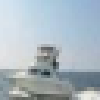

In [18]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))


       ship        deer         cat         car


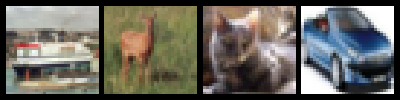

In [19]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

<br>

#### 定义网络

Autograd实现了反向传播功能，但是直接用来写深度学习的代码在很多情况下还是稍显复杂，torch.nn是专门为神经网络设计的模块化接口。nn构建于 Autograd之上，可用来定义和运行神经网络。nn.Module是nn中最重要的类，可把它看成是一个网络的封装，包含网络各层定义以及forward方法，调用forward(input)方法，可返回前向传播的结果。<br>
定义网络时，需要继承`nn.Module`，并实现它的forward方法，把网络中具有可学习参数的层放在构造函数`__init__`中。以LeNet网络为例：
![图2-7:LeNet网络结构](nn_lenet.png)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net, self).__init__()
        
        # 卷积层 '3'表示输入图片为单通道, '6'表示输出通道数，'5'表示卷积核为5*5
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # 仿射层/全连接层，y = Wx + b
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        # 卷积 -> 激活 -> 池化 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        # reshape，‘-1’表示自适应
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现(利用`autograd`)。在`forward` 函数中可使用任何tensor支持的函数，还可以使用if、for循环、print、log等Python语法，写法和标准的Python写法一致。

网络的可学习参数通过`net.parameters()`返回，`net.named_parameters`可同时返回可学习的参数及名称。

In [21]:
params = list(net.parameters())
print(len(params))

10


In [22]:
for name,parameters in net.named_parameters():
    print(name,':',parameters.size())

conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


forward函数的输入和输出都是Tensor。

In [23]:
input = t.randn(1, 3, 32, 32)
out = net(input)
out.size()

torch.Size([1, 10])

<br>
####  定义损失函数和优化器(loss和optimizer)
nn实现了神经网络中大多数的损失函数，例如nn.MSELoss用来计算均方误差，nn.CrossEntropyLoss用来计算交叉熵损失。<br>
`torch.optim`中实现了深度学习中绝大多数的优化方法，例如RMSProp、Adam、SGD等，更便于使用，因此大多数时候并不需要手动写上述代码。

In [24]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###   训练网络

所有网络的训练流程都是类似的，不断地执行如下流程：

- 输入数据
- 前向传播+反向传播
- 更新参数

In [25]:
for epoch in range(1):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.892
[1,  6000] loss: 1.711
[1,  8000] loss: 1.616
[1, 10000] loss: 1.537
[1, 12000] loss: 1.493
Finished Training


实际的label:       cat     ship     ship    plane


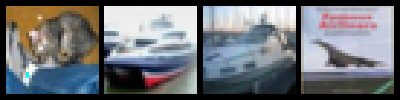

In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))


In [28]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:    cat  ship plane plane


In [26]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 46 %


####  在GPU训练
就像之前把Tensor从CPU转到GPU一样，模型也可以类似地从CPU转到GPU。

In [29]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(0.7550, device='cuda:0', grad_fn=<NllLossBackward>)

In [31]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
for epoch in range(1):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        net.to(device)
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #4 'other'

### 模型的保存和加载
#### 保存
使用torch.save()对网络结构和模型参数的保存，有两种保存方式：

保存整个神经网络的的结构信息和模型参数信息，save的对象是网络net；
保存神经网络的训练模型参数，save的对象是net.state_dict()。

#### 加载
对应上面两种保存方式，重载方式也有两种。
对应第一种完整网络结构信息，重载的时候通过torch.load(‘.pth’)直接初始化新的神经网络对象即可。
对应第二种只保存模型参数信息，需要首先导入对应的网络，通过net.load_state_dict(torch.load('.pth'))完成模型参数的重载。
在网络比较大的时候，第一种方法会花费较多的时间，所占的存储空间也比较大。


In [32]:
# 保存和加载整个模型    
t.save(net, 'model.pth')    
model = t.load('model.pth')    
  
# 仅保存和加载模型参数    
t.save(net.state_dict(), 'params.pth')    
net.load_state_dict(t.load('params.pth'))


/home/docker/.local/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
